<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/5_Benchmark_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 5 : Benchmark Study using GARCH or Kalman Filter

In [1]:
%%bash

pip install yfinance

You should consider upgrading via the '/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/bin/python3 -m pip install --upgrade pip' command.


In [5]:
import scipy.stats
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

/Users/anshumankaran/Documents/GitHub/my/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
NVDA = yf.download("NVDA", start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


## Empirical Distribution

MEAN:  365.62861645507815
SAMPLE STD 107.3641925519448
SKEWNESS:  -0.4860680960161483
KURTOSIS:  -1.2805014803056955
95% confidence interval of bootstrap means: 352.18992895507813 379.1881340942383
95% confidence interval of standard error of means: 6.41714136792589 7.123882414699473
95% confidence interval of NVDA standard deviation: 101.46391394967198 112.63847106835257


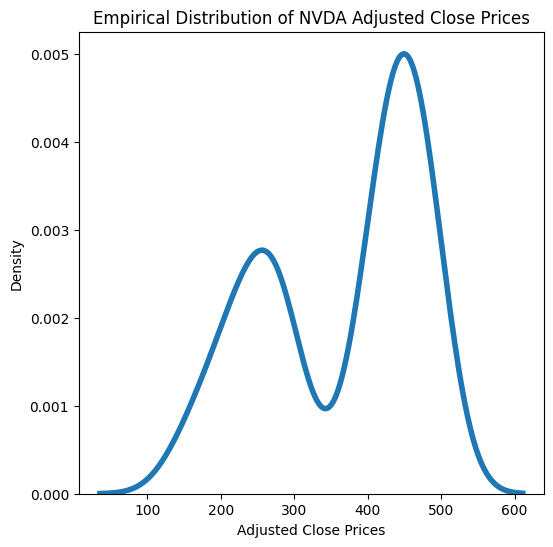

In [7]:
adj_close_prices = NVDA["Adj Close"].values

# Calculate statistical measures
mean_adj_close = np.mean(adj_close_prices)
sample_std = np.std(adj_close_prices)
skewness = scipy.stats.skew(adj_close_prices)
kurtosis = scipy.stats.kurtosis(adj_close_prices)

# Print statistical measures
print("MEAN: ", mean_adj_close)
print("SAMPLE STD", sample_std)
print("SKEWNESS: ", skewness)
print("KURTOSIS: ", kurtosis)

# Plot empirical distribution
plt.figure(figsize=(6, 6))
sns.kdeplot(data=adj_close_prices, linewidth=4)
plt.xlabel("Adjusted Close Prices")
plt.ylabel("Density")
plt.title("Empirical Distribution of NVDA Adjusted Close Prices")

# Bootstrap for confidence intervals
num_samples = adj_close_prices.shape[0]
num_bootstrap_samples = 1000
bootstrap_means = np.zeros(num_bootstrap_samples)
bootstrap_std_errors = np.zeros(num_bootstrap_samples)
bootstrap_std_devs = np.zeros(num_bootstrap_samples)

for i in range(0, num_bootstrap_samples):
    # Resample with replacement
    bootstrapped_sample = adj_close_prices[np.random.choice(num_samples, num_samples)]

    # Calculate bootstrap statistics
    bootstrap_means[i] = np.mean(bootstrapped_sample)
    bootstrap_std_errors[i] = np.std(bootstrapped_sample) / np.sqrt(num_samples)
    bootstrap_std_devs[i] = np.std(bootstrapped_sample)

# Sort bootstrap statistics
bootstrap_means = np.sort(bootstrap_means)
bootstrap_std_errors = np.sort(bootstrap_std_errors)
bootstrap_std_devs = np.sort(bootstrap_std_devs)

# Calculate and print confidence intervals
print(
    "95% confidence interval of bootstrap means:",
    bootstrap_means[25],
    bootstrap_means[975],
)
print(
    "95% confidence interval of standard error of means:",
    bootstrap_std_errors[25],
    bootstrap_std_errors[975],
)
print(
    "95% confidence interval of NVDA standard deviation:",
    bootstrap_std_devs[25],
    bootstrap_std_devs[975],
)

## Empirical Kernal Distribution

SAMPLE MEAN 365.62861645507815
SAMPLE STD 107.3641925519448


/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_56713/3580186667.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_price[t] = p1 * (u < p) + p2 * (u >= p)


confidence interval of Monte Carlo mean: 337.12277578903223 361.6892287846589


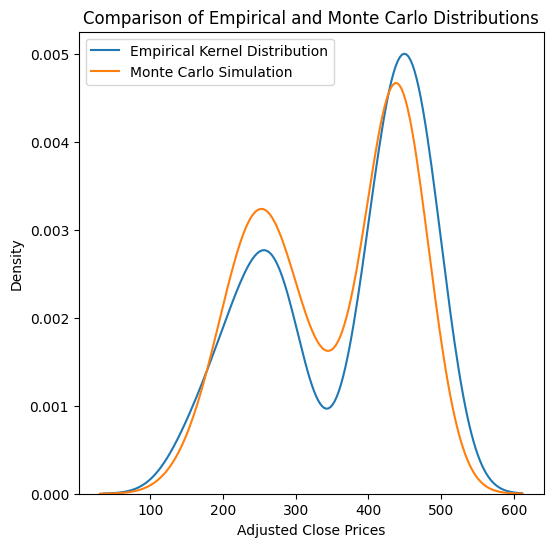

In [8]:
# Extract adjusted close prices
adj_close_prices = NVDA["Adj Close"].values
num_trading_days = len(adj_close_prices)  # number of trading days

# Calculate sample mean and standard deviation
sample_mean = np.mean(adj_close_prices)
sample_std = np.std(adj_close_prices)
print("SAMPLE MEAN", sample_mean)
print("SAMPLE STD", sample_std)

# Define parameters for the normal mixture
mu_1 = 254  # mean of the first component distribution
sigma_1 = 48  # standard deviation of the first component distribution
mu_2 = 438  # mean of the second component distribution
sigma_2 = 29  # standard deviation of the second component distribution
p = 0.48


def generate_empirical_dist(mu_1, sigma_1, mu_2, sigma_2, p, num_days):
    # Normal Mixture Simulation
    simulated_price = np.zeros(num_days - 1)
    for t in range(0, num_days - 1):
        p1 = mu_1 + sigma_1 * np.random.normal(0, 1, 1)
        p2 = mu_2 + sigma_2 * np.random.normal(0, 1, 1)
        u = np.random.uniform(0, 1, 1)
        simulated_price[t] = p1 * (u < p) + p2 * (u >= p)
    return simulated_price


# Monte Carlo Simulation
num_simulations = 1000
mc_sample_mean = np.zeros(num_simulations)
mc_aggregated = 0

for i in range(0, num_simulations):
    simulated_price = generate_empirical_dist(
        mu_1, sigma_1, mu_2, sigma_2, p, num_trading_days
    )
    mc_sample_mean[i] = np.mean(simulated_price)
    mc_aggregated += np.sort(simulated_price)

mc_aggregated = mc_aggregated / num_simulations
mc_sample_mean = np.sort(mc_sample_mean)
print(
    "confidence interval of Monte Carlo mean:", mc_sample_mean[25], mc_sample_mean[975]
)

# Visualization
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=adj_close_prices, ax=ax)  # Plot empirical distribution (blue line)
sns.kdeplot(data=mc_aggregated, ax=ax)  # Plot Monte Carlo simulation (orange line)
ax.legend(["Empirical Kernel Distribution", "Monte Carlo Simulation"])
plt.xlabel("Adjusted Close Prices")
plt.ylabel("Density")
plt.title("Comparison of Empirical and Monte Carlo Distributions")
plt.show()

## GARCH

[*********************100%%**********************]  1 of 1 completed
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_56713/1335249949.py:57: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_56713/1335249949.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_56713/1335249949.py:24: RuntimeWarning: invalid value encountered in sqrt
  F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_56713/1335249949.py:28: RuntimeWarning: invalid value encountered in log
  + (1 / 2) * np.log(v[t])
/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000g

         Current function value: -72.887105
         Iterations: 0
         Function evaluations: 189
         Gradient evaluations: 37


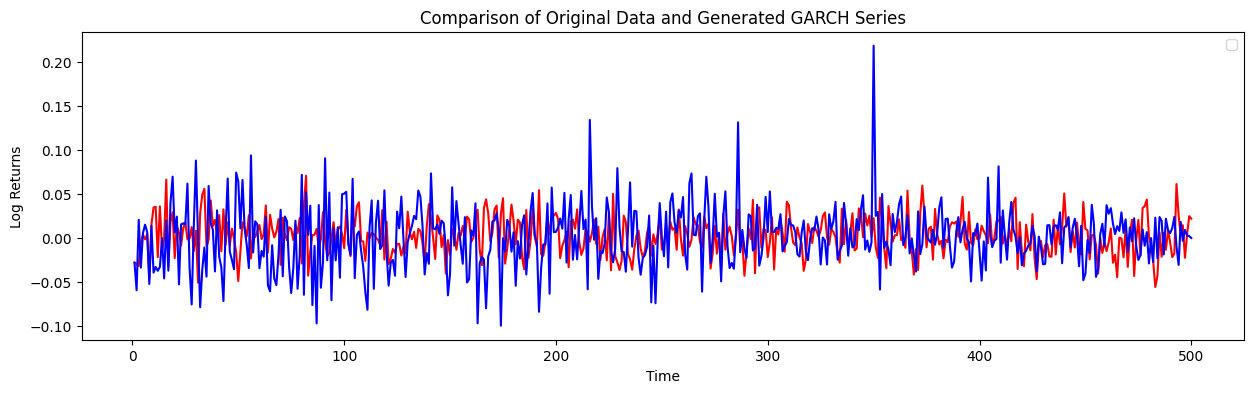

RMSE values is: 0.041561425619821346


In [9]:
# Garch Model

import numpy as np
import pandas as pd
from scipy.optimize import minimize

from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf


def GARCH(param, *args):
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (
            (1 / 2) * np.log(2 * np.pi)
            + (1 / 2) * np.log(v[t])
            + (1 / 2) * (F[t] / v[t])
        )
        Likelihood = np.sum(GARCH_Dens[1:-1])
        return Likelihood


def GARCH_PROD(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.003
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        Y[t] = mu + np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
    return Y


start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)
NVDA = yf.download("NVDA", start_date, end_date)
# Y = NVDA['Adj Close'].values
Y = np.diff(np.log(NVDA["Adj Close"].values))
T = Y.size
param0 = np.array([np.mean(Y), np.var(Y) / 4, 0.15, 0.2])
param_star = minimize(
    GARCH, param0, method="BFGS", options={"xtol": 1e-8, "disp": True}
)
Y_GARCH = GARCH_PROD(param_star.x, Y[0], T)
timevec = np.linspace(1, T, T)
plt.figure(figsize=(15, 4))
plt.plot(timevec, Y_GARCH, "r", timevec, Y, "b")
RMSE = np.sqrt(np.mean((Y_GARCH - Y) ** 2))

plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Comparison of Original Data and Generated GARCH Series")
plt.legend()
plt.show()
print("RMSE values is:", RMSE)